In [1]:
import h5py
import numpy as np

In [2]:
import pandas as pd

In [3]:
!pwd

/home/users/russelld/L1JetTagDaniel/eff


In [36]:
l = []
l1 = [1,3,4]
l2 = [5,6,7]
l3 = [0,0,0]

In [37]:
len(l3)

3

In [38]:
l.append(l3)
l.append(l1)

In [39]:
l.extend(l3)

In [43]:
l

[[0, 0, 0], [1, 3, 4], 0, 0, 0, 0, 0, 0]

In [6]:
!pwd

/home/users/russelld/L1JetTagDaniel/eff


In [33]:
with h5py.File("list"  + ".h5", "w") as hf:
    hf.create_dataset("Testing Data", data=l)

In [7]:
fTrain = "4b/M_LLP_30_ctau_1/newTrainDataSignalOnly_PT20.h5"
sample = "4b/M_LLP_30_ctau_1/newSampleDataSignalOnly_PT20.h5"
fTest =  "4b/M_LLP_30_ctau_1/newTestDataSignalOnly_PT20.h5"
jet = "4b/M_LLP_30_ctau_1/newJetDataSignalOnly_PT20.h5"

In [8]:
with h5py.File(fTrain, "r") as hf:
    trainData = hf["Training Data"][:]
with h5py.File(sample, "r") as hf:
    sampleData = hf["Sample Data"][:] #Contains ("Pt", "Eta", "Phi", "M")

with h5py.File(fTest, "r") as hf:
    testData = hf["Testing Data"][:]
with h5py.File(jet, "r") as hf:
    jetData = hf["Jet Data"][:] #Contains ("Pt", "Eta", "Phi", "M")

In [9]:
testData.shape, jetData.shape, trainData.shape, sampleData.shape #Lengths match

((18180, 146), (18180, 6), (27175, 146), (27175, 6))

In [10]:
stackedData = np.vstack((trainData, testData))

In [11]:
stackedJetData = np.vstack((sampleData, jetData))

In [12]:
stackedData.shape

(45355, 146)

In [13]:
A = stackedData[:,0:140] #Jet Features
b = stackedData[:, 140] #Labels
eventNum = stackedData[:, 141] #Event number per jet
LLPfeats = stackedData[:, 142:len(stackedData[0])] #LLP features (pT, Eta, Phi, Mass)

In [15]:
#Reshape features to 10x14
N_PART_PER_JET = 10
N_FEAT = 14
A = A.reshape((A.shape[0], N_PART_PER_JET, N_FEAT))

In [16]:
from qkeras.utils import load_qmodel
#import model that was trained with "full" dataset (containing all samples)
model = load_qmodel("/home/users/russelld/L1JetTagDaniel/hls4mlModifications/10-08-23/02-02_Scripts/stop_4b_4c/qkL1JetTagModel.h5")

2025-04-11 15:58:37.028740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 15:59:29.371074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

In [18]:
pred = model.predict(A)

1418/1418 [==============================] - 1s 647us/step


In [19]:
pred

array([[0.99537694],
       [0.97079873],
       [0.9988316 ],
       ...,
       [0.99022555],
       [0.99962074],
       [0.9980219 ]], dtype=float32)

Remember, `stackedJetData` contains ("Pt", "Eta", "Phi", "M") in that order

In [20]:
d = {"JetPt": stackedJetData[:,0], "JetEta": stackedJetData[:,1], "JetPhi": stackedJetData[:,2], \
    "JetMass": stackedJetData[:,3], "labels": b, "prediction": pred.ravel(), "EventNum": eventNum  }
dLLP =  {"LLPpt": LLPfeats[:,0], "LLPeta": LLPfeats[:,1], "LLPphi":  LLPfeats[:,2], \
    "LLPmass": LLPfeats[:,3], "labels": b, "prediction": pred.ravel(), "EventNum": eventNum  }

In [21]:
events = pd.DataFrame(d)
LLPs = pd.DataFrame(dLLP)

In [22]:
events.keys(), LLPs.keys()

(Index(['JetPt', 'JetEta', 'JetPhi', 'JetMass', 'labels', 'prediction',
        'EventNum'],
       dtype='object'),
 Index(['LLPpt', 'LLPeta', 'LLPphi', 'LLPmass', 'labels', 'prediction',
        'EventNum'],
       dtype='object'))

In [23]:
#events[0:10]
LLPs[0:10]

,LLPpt,LLPeta,LLPphi,LLPmass,labels,prediction,EventNum
0,132.186325,-0.819579,-1.980046,30.0,1.0,0.995377,1.0
1,75.606682,-1.854408,0.896024,30.0,1.0,0.970799,2.0
2,47.046223,-1.204688,-0.973152,30.0,1.0,0.998832,3.0
3,71.505264,-0.069205,2.869853,30.0,1.0,0.996216,4.0
4,53.337826,0.660996,0.997543,30.0,1.0,0.986828,4.0
5,115.339157,0.259684,1.898416,30.0,1.0,0.988458,5.0
6,55.075840,-1.946823,-0.606859,30.0,1.0,0.996066,6.0
7,203.372238,-1.749777,2.981036,30.0,1.0,0.789721,9.0
8,90.807106,-1.772894,-2.493358,30.0,1.0,0.755637,9.0
9,177.385101,-1.490101,-1.613407,30.0,1.0,0.938124,10.0


In [25]:
EventGroups = events.groupby("EventNum").apply(lambda x: x.sort_values(by="JetPt", ascending=False)) #sorted by Pt
LLPsByGroupedEvents = LLPs.groupby("EventNum").apply(lambda x: x.sort_values(by="LLPpt", ascending=False)) #sorted by Pt

/tmp/ipykernel_4011542/1536975645.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  LLPsByGroupedEvents = LLPs.groupby("EventNum").apply(lambda x: x.sort_values(by="LLPpt", ascending=False)) #sorted by Pt


Trying things:

In [21]:
Pt_EventGroups = events.groupby("EventNum")[["JetPt", "prediction"]].apply(lambda x: x.sort_values(by="JetPt", ascending=False))

In [22]:
# Mask to keep first elements from each group (event)
mask = Pt_EventGroups.index.get_level_values(0).duplicated(keep='first')[0:10]

In [23]:
Pt_EventGroups[0:10][~mask] #see that no events repeat

,,JetPt,prediction
EventNum,,,
1.0,0,99.890553,0.995377
2.0,1,35.103127,0.970799
3.0,2,31.466686,0.998832
4.0,3,56.204201,0.996216
5.0,5,76.414378,0.988458
6.0,6,21.747021,0.996066
9.0,7,95.500000,0.789721
10.0,9,22.922380,0.938124


In [26]:
# Mask to keep first elements from each group (event)
maskEvents = EventGroups.index.get_level_values(0).duplicated(keep='first')
maskLLPs = LLPsByGroupedEvents.index.get_level_values(0).duplicated(keep='first')

In [29]:
# Mask to keep first elements from each group (event)
onlineEvents = EventGroups[~maskEvents]
onlineLLPs = LLPsByGroupedEvents[~maskLLPs]

In [30]:
#NN score cut
OnEvents_85 = onlineEvents.loc[onlineEvents["prediction"]> 0.85]
OnLLPs_85 = onlineLLPs.loc[onlineLLPs["prediction"]>0.85]

In [31]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

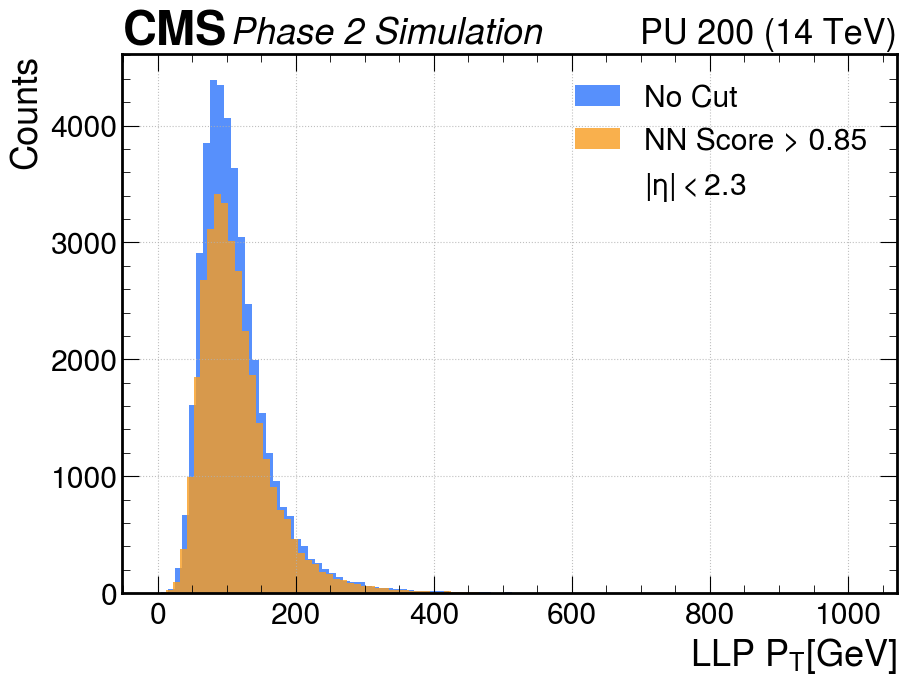

In [60]:
pylab.figure(figsize=(10,7))
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
# pylab.hist(onlineEvents["JetPt"], bins=100,); #density=True);
# pylab.hist(OnEvents_85["JetPt"], bins=100, alpha = 0.8); #density=True, alpha = 0.8);
pylab.hist(onlineLLPs["LLPpt"], bins=100, label="No Cut"); #density=True);
pylab.hist(OnLLPs_85["LLPpt"], bins=100, alpha = 0.8, label="NN Score > 0.85"); #density=True, alpha = 0.8);
plt.plot(0,0, label="$|\eta| < 2.3$", alpha = 0)
pylab.ylabel("Counts")
pylab.xlabel("LLP $P_T [GeV]$")
plt.legend()
plt.grid(True)

In [36]:
pt_ths = np.linspace(40, 420, 20)

In [56]:
pt_ths

array([ 40.,  60.,  80., 100., 120., 140., 160., 180., 200., 220., 240.,
       260., 280., 300., 320., 340., 360., 380., 400., 420.])

In [38]:
eff = []
effLLP = []
for pt in pt_ths:
    eff.append(len(OnEvents_85.loc[OnEvents_85["JetPt"] < pt])/ len(onlineEvents.loc[onlineEvents["JetPt"] < pt]))
    effLLP.append(len(OnLLPs_85.loc[OnLLPs_85["LLPpt"] < pt])/ len(onlineLLPs.loc[onlineLLPs["LLPpt"] < pt]))

Text(1, 0, 'LLP $P_T [GeV]$')

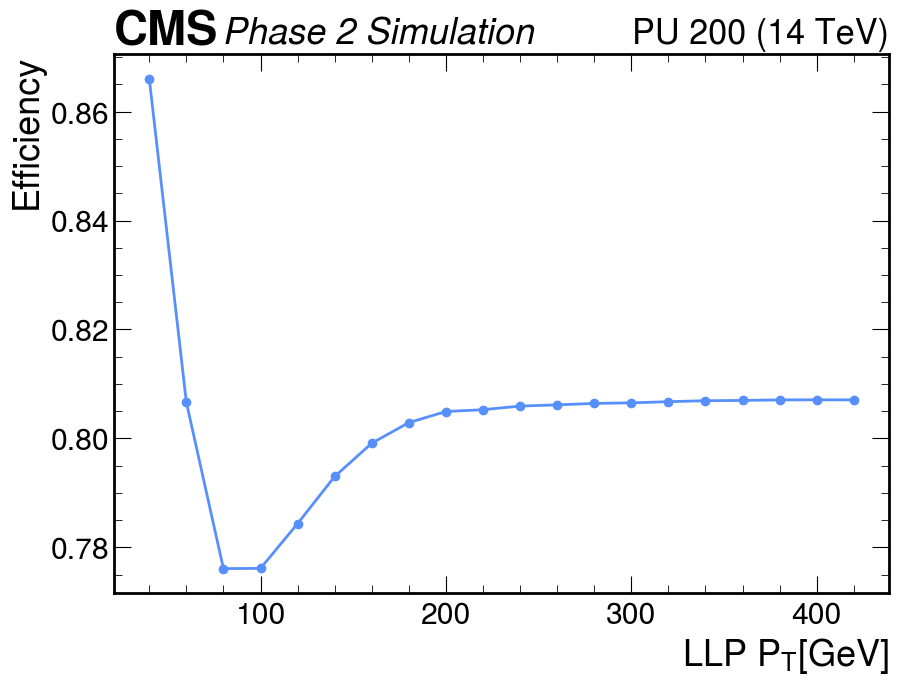

In [54]:
pylab.figure(figsize=(10,7))
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
#pylab.scatter(pt_ths, eff)
#pylab.plot(pt_ths, eff,)
#pylab.bar(pt_ths, eff, width=5)
#pylab.errorbar(pt_ths, eff, xerr=20, yerr=0.01)
pylab.scatter(pt_ths, effLLP)
pylab.plot(pt_ths, effLLP)
pylab.ylabel("Efficiency")
pylab.xlabel("LLP $P_T [GeV]$")
#pylab.ylim(0.4, 1)

In [50]:
eta_ths = np.linspace(-2.1, 2.1, 20)

In [51]:
eff2 = []
eff2LLP = []
for eta in eta_ths:
    eff2.append(len(OnEvents_85.loc[OnEvents_85["JetEta"] < eta])/ len(onlineEvents.loc[onlineEvents["JetEta"] < eta]))
    try:
        eff2LLP.append(len(OnLLPs_85.loc[OnLLPs_85["LLPeta"] < eta])/ len(onlineLLPs.loc[onlineLLPs["LLPeta"] < eta]))
    except: ZeroDivisionError

In [52]:
len(eff2LLP), len(eta_ths)

(20, 20)

Text(1, 0, '$\\eta$')

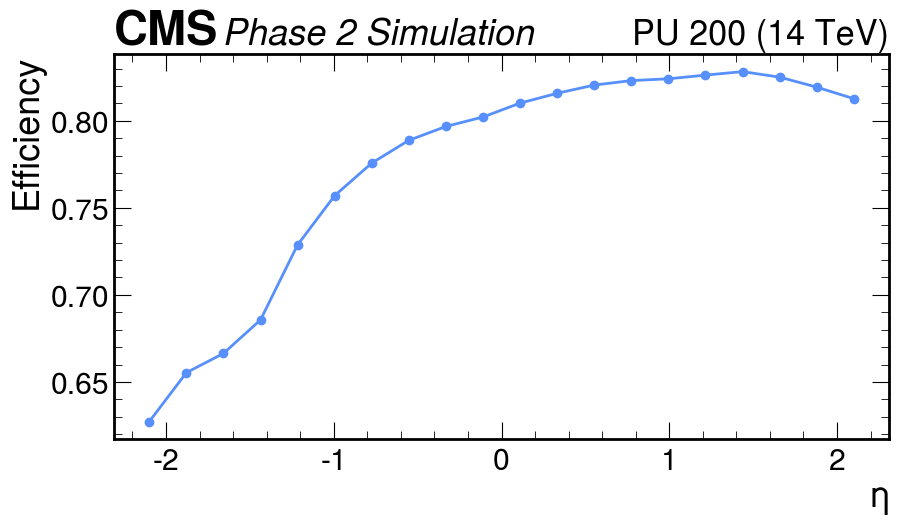

In [53]:
pylab.figure(figsize=(10,5))
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
#pylab.scatter(eta_ths, eff2)
#pylab.plot(eta_ths, eff2)
pylab.scatter(eta_ths, eff2LLP)
pylab.plot(eta_ths, eff2LLP)
pylab.ylabel("Efficiency")
pylab.xlabel("$\eta$")

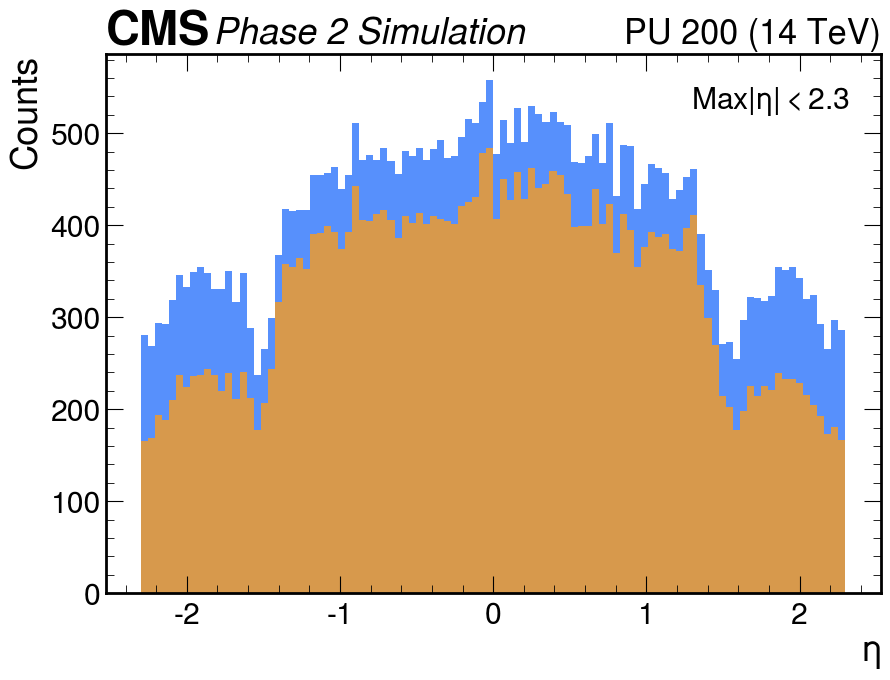

In [66]:
pylab.figure(figsize=(10,7))
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
# pylab.hist(onlineEvents["JetEta"], bins=100,); #density=True);
# pylab.hist(OnEvents_85["JetEta"], bins=100, alpha = 0.8); #density=True, alpha = 0.8);
pylab.hist(onlineLLPs["LLPeta"], bins=100,); #density=True);
pylab.hist(OnLLPs_85["LLPeta"], bins=100, alpha = 0.8); #density=True, alpha = 0.8);
plt.plot(0,0, label="$ Max |\eta| < 2.3$", alpha = 0)
pylab.xlabel("$\eta$")
pylab.ylabel("Counts")
plt.legend()

In [181]:
len(OnEvents_85)

33203

In [182]:
len(onlineEvents)

41058